# More CM2.6 filtering

In this notebook, we use the `MOM5T` Laplacian from `GCM-filters` to filter a single time step of the ocean's sensible heat term

In [3]:
import xarray as xr
import gcm_filters
import matplotlib.pyplot as plt

## Load data

### Load ocean boundary flux terms (monthly air-sea fields)

In [4]:
from intake import open_catalog
cat = open_catalog("https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean/GFDL_CM2.6.yaml")
ds_oc  = cat["GFDL_CM2_6_control_ocean_boundary_flux"].to_dask()

In [2]:
ds_oc

<xarray.Dataset>
Dimensions:                    (time: 240, yu_ocean: 2700, xu_ocean: 3600,
                                yt_ocean: 2700, xt_ocean: 3600, nv: 2)
Coordinates:
    geolat_c                   (yu_ocean, xu_ocean) float32 dask.array<chunksize=(338, 450), meta=np.ndarray>
    geolat_t                   (yt_ocean, xt_ocean) float32 dask.array<chunksize=(338, 450), meta=np.ndarray>
    geolon_c                   (yu_ocean, xu_ocean) float32 dask.array<chunksize=(338, 450), meta=np.ndarray>
    geolon_t                   (yt_ocean, xt_ocean) float32 dask.array<chunksize=(338, 450), meta=np.ndarray>
  * nv                         (nv) float64 1.0 2.0
  * time                       (time) object 0181-01-16 12:00:00 ... 0200-12-...
  * xt_ocean                   (xt_ocean) float64 -279.9 -279.8 ... 79.85 79.95
  * xu_ocean                   (xu_ocean) float64 -279.9 -279.8 ... 79.9 80.0
  * yt_ocean                   (yt_ocean) float64 -81.11 -81.07 ... 89.94 89.98
  * yu_ocean                   (yu_ocean) float64 -81.09 -81.05 ... 89.96 90.0
Data variables: (12/27)
    bottom_power_u             (time, yu_ocean, xu_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    bottom_power_v             (time, yu_ocean, xu_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    calving_melt_heat          (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    ekman_heat                 (time, yu_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    ekman_we                   (time, yu_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    evap                       (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    ...                         ...
    sfc_hflux_pme              (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    swflx                      (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    tau_x                      (time, yu_ocean, xu_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    tau_y                      (time, yu_ocean, xu_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    wind_power_u               (time, yu_ocean, xu_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    wind_power_v               (time, yu_ocean, xu_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
Attributes:
    filename:   01810101.ocean_bdy_flux.nc
    grid_tile:  1
    grid_type:  mosaic
    title:      CM2.6_miniBling

### Load ocean model grid

The model grid coordinates are stored in a separate zarr store, so we load them below.

In [6]:
ds_oc_grid  = cat["GFDL_CM2_6_grid"].to_dask()

In [34]:
ds_oc_grid

<xarray.Dataset>
Dimensions:         (yt_ocean: 2700, xt_ocean: 3600, yu_ocean: 2700,
                     xu_ocean: 3600, st_edges_ocean: 51, st_ocean: 50,
                     sw_edges_ocean: 51, sw_ocean: 50)
Coordinates: (12/27)
    area_t          (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    area_u          (yu_ocean, xu_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dxt             (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dxu             (yu_ocean, xu_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dyt             (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dyu             (yu_ocean, xu_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    ...              ...
  * sw_ocean        (sw_ocean) float64 10.07 20.16 30.29 ... 5.29e+03 5.5e+03
    wet             (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
  * xt_ocean        (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.85 79.95
  * xu_ocean        (xu_ocean) float64 -279.9 -279.8 -279.7 ... 79.8 79.9 80.0
  * yt_ocean        (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.94 89.98
  * yu_ocean        (yu_ocean) float64 -81.09 -81.05 -81.0 ... 89.92 89.96 90.0
Data variables:
    *empty*
Attributes:
    NCO:      4.0.3

### Merge together into one dataset

In [7]:
ds = xr.merge([ds_oc,ds_oc_grid],compat='override')

In [8]:
ds

<xarray.Dataset>
Dimensions:                    (time: 240, yu_ocean: 2700, xu_ocean: 3600,
                                yt_ocean: 2700, xt_ocean: 3600, nv: 2,
                                st_edges_ocean: 51, st_ocean: 50,
                                sw_edges_ocean: 51, sw_ocean: 50)
Coordinates: (12/29)
    geolat_c                   (yu_ocean, xu_ocean) float32 dask.array<chunksize=(338, 450), meta=np.ndarray>
    geolat_t                   (yt_ocean, xt_ocean) float32 dask.array<chunksize=(338, 450), meta=np.ndarray>
    geolon_c                   (yu_ocean, xu_ocean) float32 dask.array<chunksize=(338, 450), meta=np.ndarray>
    geolon_t                   (yt_ocean, xt_ocean) float32 dask.array<chunksize=(338, 450), meta=np.ndarray>
  * nv                         (nv) float64 1.0 2.0
  * time                       (time) object 0181-01-16 12:00:00 ... 0200-12-...
    ...                         ...
    kmu                        (yu_ocean, xu_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
  * st_edges_ocean             (st_edges_ocean) float64 0.0 10.07 ... 5.5e+03
  * st_ocean                   (st_ocean) float64 5.034 15.1 ... 5.395e+03
  * sw_edges_ocean             (sw_edges_ocean) float64 5.034 15.1 ... 5.5e+03
  * sw_ocean                   (sw_ocean) float64 10.07 20.16 ... 5.5e+03
    wet                        (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
Data variables: (12/27)
    bottom_power_u             (time, yu_ocean, xu_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    bottom_power_v             (time, yu_ocean, xu_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    calving_melt_heat          (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    ekman_heat                 (time, yu_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    ekman_we                   (time, yu_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    evap                       (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    ...                         ...
    sfc_hflux_pme              (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    swflx                      (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    tau_x                      (time, yu_ocean, xu_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    tau_y                      (time, yu_ocean, xu_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    wind_power_u               (time, yu_ocean, xu_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    wind_power_v               (time, yu_ocean, xu_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
Attributes:
    filename:   01810101.ocean_bdy_flux.nc
    grid_tile:  1
    grid_type:  mosaic
    title:      CM2.6_miniBling

## Remove the Arctic region

This is necessary to remove very small grid scales that pop up and cause trouble when computing a filter of 100km.

In [9]:
ds_noArctic = ds.isel(yt_ocean=slice(0,2000),yu_ocean=slice(0,2000))
ds_noArctic

<xarray.Dataset>
Dimensions:                    (time: 240, yu_ocean: 2000, xu_ocean: 3600,
                                yt_ocean: 2000, xt_ocean: 3600, nv: 2,
                                st_edges_ocean: 51, st_ocean: 50,
                                sw_edges_ocean: 51, sw_ocean: 50)
Coordinates: (12/29)
    geolat_c                   (yu_ocean, xu_ocean) float32 dask.array<chunksize=(338, 450), meta=np.ndarray>
    geolat_t                   (yt_ocean, xt_ocean) float32 dask.array<chunksize=(338, 450), meta=np.ndarray>
    geolon_c                   (yu_ocean, xu_ocean) float32 dask.array<chunksize=(338, 450), meta=np.ndarray>
    geolon_t                   (yt_ocean, xt_ocean) float32 dask.array<chunksize=(338, 450), meta=np.ndarray>
  * nv                         (nv) float64 1.0 2.0
  * time                       (time) object 0181-01-16 12:00:00 ... 0200-12-...
    ...                         ...
    kmu                        (yu_ocean, xu_ocean) float32 dask.array<chunksize=(2000, 3600), meta=np.ndarray>
  * st_edges_ocean             (st_edges_ocean) float64 0.0 10.07 ... 5.5e+03
  * st_ocean                   (st_ocean) float64 5.034 15.1 ... 5.395e+03
  * sw_edges_ocean             (sw_edges_ocean) float64 5.034 15.1 ... 5.5e+03
  * sw_ocean                   (sw_ocean) float64 10.07 20.16 ... 5.5e+03
    wet                        (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2000, 3600), meta=np.ndarray>
Data variables: (12/27)
    bottom_power_u             (time, yu_ocean, xu_ocean) float32 dask.array<chunksize=(1, 2000, 3600), meta=np.ndarray>
    bottom_power_v             (time, yu_ocean, xu_ocean) float32 dask.array<chunksize=(1, 2000, 3600), meta=np.ndarray>
    calving_melt_heat          (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2000, 3600), meta=np.ndarray>
    ekman_heat                 (time, yu_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2000, 3600), meta=np.ndarray>
    ekman_we                   (time, yu_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2000, 3600), meta=np.ndarray>
    evap                       (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2000, 3600), meta=np.ndarray>
    ...                         ...
    sfc_hflux_pme              (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2000, 3600), meta=np.ndarray>
    swflx                      (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2000, 3600), meta=np.ndarray>
    tau_x                      (time, yu_ocean, xu_ocean) float32 dask.array<chunksize=(1, 2000, 3600), meta=np.ndarray>
    tau_y                      (time, yu_ocean, xu_ocean) float32 dask.array<chunksize=(1, 2000, 3600), meta=np.ndarray>
    wind_power_u               (time, yu_ocean, xu_ocean) float32 dask.array<chunksize=(1, 2000, 3600), meta=np.ndarray>
    wind_power_v               (time, yu_ocean, xu_ocean) float32 dask.array<chunksize=(1, 2000, 3600), meta=np.ndarray>
Attributes:
    filename:   01810101.ocean_bdy_flux.nc
    grid_tile:  1
    grid_type:  mosaic
    title:      CM2.6_miniBling

In [10]:
# Find the minimum grid spacing
dx_min = min(ds_noArctic.dxt.where(ds_noArctic.wet).min(), ds_noArctic.dyt.where(ds_noArctic.wet).min())
dx_min = dx_min.values
dx_min

array(1831.93785406)

## Set up and compute the `MOM5T` Laplacian

In [11]:
# List required variables for this `MOM5T` filter
gcm_filters.required_grid_vars(gcm_filters.GridType.MOM5T)

['wet_mask', 'dxt', 'dyt', 'dxu', 'dyu', 'area_t']

In [12]:
dxu = ds_noArctic.dxu.swap_dims({"xu_ocean": "xt_ocean","yu_ocean": "yt_ocean"})
dyu = ds_noArctic.dyu.swap_dims({"xu_ocean": "xt_ocean","yu_ocean": "yt_ocean"})

In [13]:
specs = {
    'filter_scale': 100000, # 100km in m
    'dx_min': dx_min,
    'filter_shape': gcm_filters.FilterShape.GAUSSIAN
}

filter_MOM5T = gcm_filters.Filter(
    **specs,
    grid_type = gcm_filters.GridType.MOM5T,
    grid_vars = {'wet_mask':ds_noArctic.wet,'dxt':ds_noArctic.dxt,'dyt':ds_noArctic.dyt,
                 'dxu':dxu,'dyu':dyu,'area_t':ds_noArctic.area_t}
)

In [14]:
filter_MOM5T

Filter(filter_scale=100000, dx_min=array(1831.93785406), filter_shape=<FilterShape.GAUSSIAN: 1>, transition_width=3.141592653589793, ndim=2, n_steps=61, n_iterations=1, grid_type=<GridType.MOM5T: 7>)

In [15]:
# Create the test data: sensible heat (single timestep)
test_data = ds_noArctic.sens_heat.isel(time=0)
test_data

<xarray.DataArray 'sens_heat' (yt_ocean: 2000, xt_ocean: 3600)>
dask.array<getitem, shape=(2000, 3600), dtype=float32, chunksize=(2000, 3600), chunktype=numpy.ndarray>
Coordinates:
    geolat_t  (yt_ocean, xt_ocean) float32 dask.array<chunksize=(338, 450), meta=np.ndarray>
    geolon_t  (yt_ocean, xt_ocean) float32 dask.array<chunksize=(338, 450), meta=np.ndarray>
    time      object 0181-01-16 12:00:00
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 -80.98 ... 59.9 59.95 60.0
    area_t    (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2000, 3600), meta=np.ndarray>
    dxt       (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2000, 3600), meta=np.ndarray>
    dyt       (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2000, 3600), meta=np.ndarray>
    ht        (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2000, 3600), meta=np.ndarray>
    kmt       (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2000, 3600), meta=np.ndarray>
    wet       (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2000, 3600), meta=np.ndarray>
Attributes:
    cell_methods:   time: mean
    long_name:      sensible heat into ocean (<0 cools ocean)
    standard_name:  surface_downward_sensible_heat_flux
    time_avg_info:  average_T1,average_T2,average_DT
    units:          W/m^2
    valid_range:    [-10000000000.0, 10000000000.0]

In [16]:
# Apply the filter
result = filter_MOM5T.apply(test_data, dims=['yt_ocean','xt_ocean']) 

In [18]:
%time mom_filtered = result.load()

/srv/conda/envs/notebook/lib/python3.9/site-packages/gcm_filters/kernels.py:404: RuntimeWarning: divide by zero encountered in true_divide
  out1 /= self.area_t
/srv/conda/envs/notebook/lib/python3.9/site-packages/gcm_filters/kernels.py:404: RuntimeWarning: invalid value encountered in true_divide
  out1 /= self.area_t
/srv/conda/envs/notebook/lib/python3.9/site-packages/gcm_filters/kernels.py:410: RuntimeWarning: invalid value encountered in true_divide
  out2 /= self.area_t


CPU times: user 24 s, sys: 6.86 s, total: 30.9 s
Wall time: 29.5 s


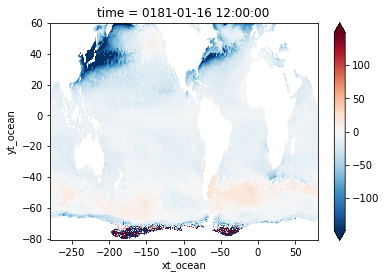

In [32]:
mom_filtered.plot(robust=True)

## Use IRREGULAR_WITH_LAND filter

In [33]:
# List required variables for this `MOM5T` filter
gcm_filters.required_grid_vars(gcm_filters.GridType.IRREGULAR_WITH_LAND)

['wet_mask', 'dxw', 'dyw', 'dxs', 'dys', 'area', 'kappa_w', 'kappa_s']

This won't work because it needs a southwest convention, while MOM5 uses northeast convention. (See e.g. the code for the Laplacians [here](https://github.com/ocean-eddy-cpt/gcm-filters/blob/e4177da86036b5962bb0bfb3ed9dbab23c723c42/gcm_filters/kernels.py#L375))

## Why do we need to cut out the Arctic to use the `MOM5T` Laplacian?

If we don't cut out the Arctic, then we get some stray grid cells that have very small grid lengths:

In [30]:
# Find the minimum grid spacing
dx_min = min(ds.dxt.where(ds.wet).min(), ds.dyt.where(ds.wet).min())
dx_min = dx_min.values
dx_min

array(865.79775507)

865 meters is very small compared to scales we might want to filter by (e.g. 100km as in the above example). This then yields numerical instability when computing the filter (see the warning below that tells us `Filter scale much larger than grid scale -> numerical instability possible`). The below cells show the result:

In [31]:
dxu = ds.dxu.swap_dims({"xu_ocean": "xt_ocean","yu_ocean": "yt_ocean"})
dyu = ds.dyu.swap_dims({"xu_ocean": "xt_ocean","yu_ocean": "yt_ocean"})

In [32]:
specs = {
    'filter_scale': 100000, # 100km in m
    'dx_min': dx_min,
    'filter_shape': gcm_filters.FilterShape.GAUSSIAN
}

filter_MOM5T_Arctic = gcm_filters.Filter(
    **specs,
    grid_type = gcm_filters.GridType.MOM5T,
    grid_vars = {'wet_mask':ds.wet,'dxt':ds.dxt,'dyt':ds.dyt,
                 'dxu':dxu,'dyu':dyu,'area_t':ds.area_t}
)

<string>:12: UserWarning: Filter scale much larger than grid scale -> numerical instability possible. More information on numerical instability can be found at https://gcm-filters.readthedocs.io/en/latest/theory.html.


In [33]:
filter_MOM5T_Arctic

Filter(filter_scale=100000, dx_min=array(865.79775507), filter_shape=<FilterShape.GAUSSIAN: 1>, transition_width=3.141592653589793, ndim=2, n_steps=128, n_iterations=1, grid_type=<GridType.MOM5T: 7>)

In [35]:
# Create the test data: sensible heat (single timestep)
test_data = ds.sens_heat.isel(time=0)
test_data

<xarray.DataArray 'sens_heat' (yt_ocean: 2700, xt_ocean: 3600)>
dask.array<getitem, shape=(2700, 3600), dtype=float32, chunksize=(2700, 3600), chunktype=numpy.ndarray>
Coordinates:
    geolat_t  (yt_ocean, xt_ocean) float32 dask.array<chunksize=(338, 450), meta=np.ndarray>
    geolon_t  (yt_ocean, xt_ocean) float32 dask.array<chunksize=(338, 450), meta=np.ndarray>
    time      object 0181-01-16 12:00:00
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
    area_t    (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dxt       (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dyt       (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    ht        (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    kmt       (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    wet       (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
Attributes:
    cell_methods:   time: mean
    long_name:      sensible heat into ocean (<0 cools ocean)
    standard_name:  surface_downward_sensible_heat_flux
    time_avg_info:  average_T1,average_T2,average_DT
    units:          W/m^2
    valid_range:    [-10000000000.0, 10000000000.0]

In [36]:
# Apply the filter
result = filter_MOM5T_Arctic.apply(test_data, dims=['yt_ocean','xt_ocean']) 

/srv/conda/envs/notebook/lib/python3.9/site-packages/gcm_filters/kernels.py:404: RuntimeWarning: divide by zero encountered in true_divide
  out1 /= self.area_t
/srv/conda/envs/notebook/lib/python3.9/site-packages/gcm_filters/kernels.py:404: RuntimeWarning: invalid value encountered in true_divide
  out1 /= self.area_t
/srv/conda/envs/notebook/lib/python3.9/site-packages/gcm_filters/kernels.py:410: RuntimeWarning: invalid value encountered in true_divide
  out2 /= self.area_t


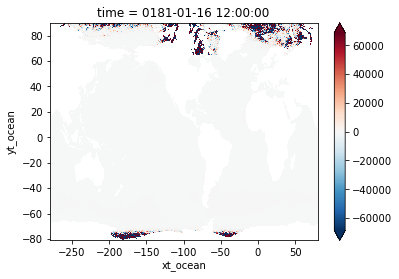

In [37]:
# Filtered field
result.plot(robust=True)

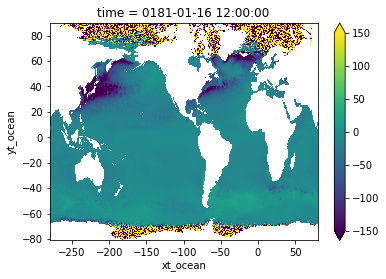

In [38]:
# Filtered field
result.plot(vmin=-150,vmax=150)

### Where are the trouble points?

Let's plot `dxt` and `dyt`:

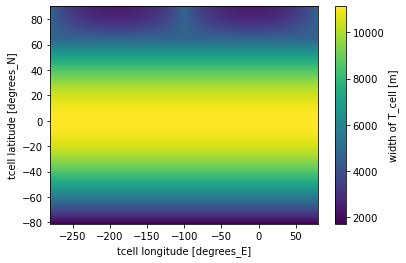

In [10]:
ds.dxt.plot()

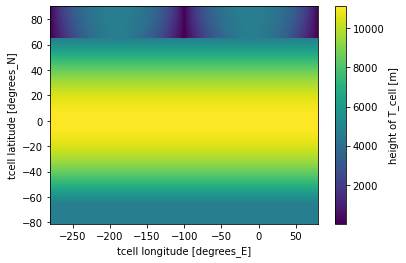

In [39]:
ds.dyt.plot()

Looks like `dyt` has some small values, so let's zoom in on those that are less than 900.

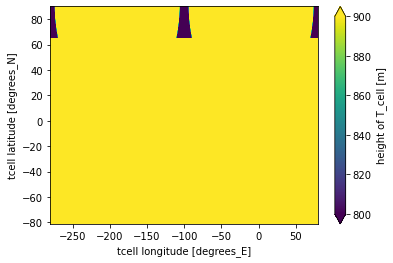

In [40]:
ds.dyt.plot(vmin=800,vmax=900)

We are guessing that these points should be covered by the wet mask, but that apparently is not the case for at least some of these points. 

Below I plot `dyt` masked by the wet mask and just those points < 1000 to see where they are located.

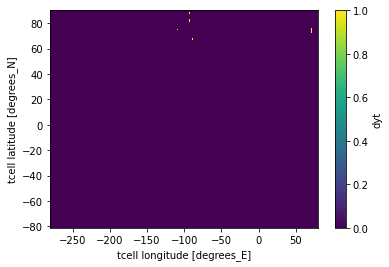

In [28]:
(ds.dyt.where(ds.wet)<1000).plot()

They seem to be located entirely in the Arctic and on the boundaries of the plot just above. This suggests that the wet mask is not entirely masking out these problem points.

### Test if the trouble points yielding very small dyt can be removed by expanding the wet mask

Let's try using `scikit image`'s `erosion()` to expand the wet mask to see if this masks the small cell area points

In [25]:
from skimage.morphology import erosion, disk

wet_mask_lg = erosion(ds.wet, selem=disk(10)) 

/tmp/ipykernel_851/3737035846.py:3: FutureWarning: `selem` is a deprecated argument name for `erosion`. It will be removed in version 1.0. Please use `footprint` instead.
  wet_mask_lg = erosion(ds.wet, selem=disk(10))


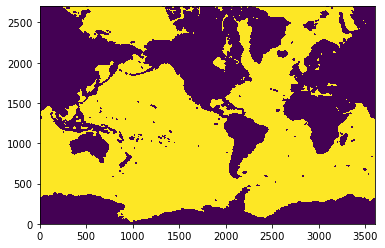

In [26]:
import matplotlib.pyplot as plt
plt.pcolormesh(wet_mask_lg)

In [27]:
# Find the minimum grid spacing
dx_min = min(ds.dxt.where(wet_mask_lg).min(), ds.dyt.where(wet_mask_lg).min())
dx_min = dx_min.values
dx_min

array(1089.50739027)

We do see that the minimum grid length increases as we increase the erosion amount. But it's unclear where the cut-off is for grid sizes that make sense and are not too small. Perhaps we could do a histogram to view the grid cells that are outliers.

### Extras

To emphasize the grid cells that are too small, we can use `erosion()`

In [21]:
test = (ds.dyt.where(ds.wet)<1500) ==0
test = erosion(test, selem=disk(10))

/tmp/ipykernel_772/2343531544.py:2: FutureWarning: `selem` is a deprecated argument name for `erosion`. It will be removed in version 1.0. Please use `footprint` instead.
  test = erosion(test, selem=disk(10))


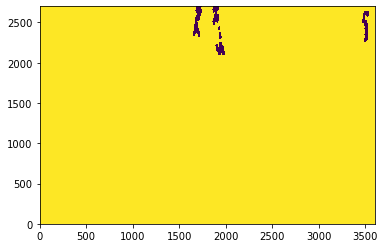

In [22]:
plt.pcolormesh(test)

We should start an issue in GCM-filters for this. Should GCM-filters handle this somehow?